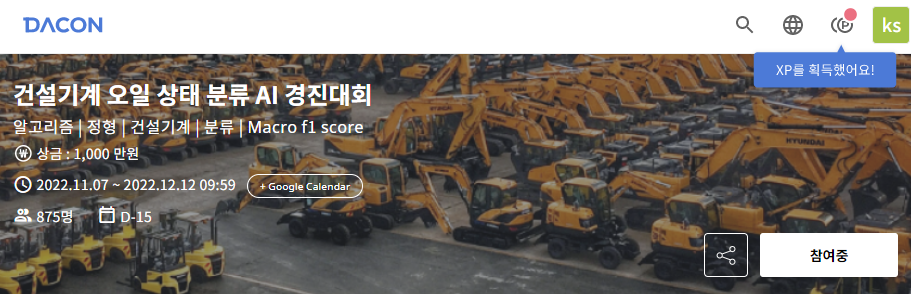

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [184]:
file_version = 105
CFG = {
    'EPOCHS': 30,
    'BATCH_SIZE':256,  #256  128  512
    'SEED':1,     #43
    'log_transform_turn': 1,  # 로그 트랜스폼을 몇번 돌릴 것인가?
    'skew_cut':0,           # 왜도값 얼마 초과시 로그 트랜스폼 할 것인가?
    'vif_cut': 10,           # 다중공선성 vif 얼마 이상을 제거할 것인가?
    'corr_cut': [0.045, 0.045, 0.05, 0.05],     # 일정 상관관계 이하 칼럼은 드랍
    
    'drop_rate': 0.3,     # overfit을 해소하기 위한 nn model dropout 비율 (0.1 ~ 0.5)  
    'reduct' : 'mean',      # BCELoss function reduction option : sum, mean
    'T_LEARNING_RATE': [3e-2, 1e-3, 1e-2, 1e-3],    # 0.01
    'T_Thresh': [0.3, 0.3, 0.3, 0.3],   # Teacher model train Threshhold 최초 0.35
    'S_LEARNING_RATE': [3e-2, 1e-3, 1e-2, 1e-3],    # 0.01
    'S_Thresh': [0.3, 0.3, 0.3, 0.3],     # Student model train Threshold 최초 0.35
    'alpha': 0.1   # distillation loss function 반영 비율
}
scaler = StandardScaler()  # StandardScaler, MinMaxScaler, RobustScaler

In [185]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 1. EDA

- 결측치 처리
- 왜도 정규화 처리
- 스케일링
- 다중공선성 검토

In [186]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [187]:
train["Y_LABEL"].value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

In [188]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [189]:
# test.info()

## (1) 결측치

<AxesSubplot:>

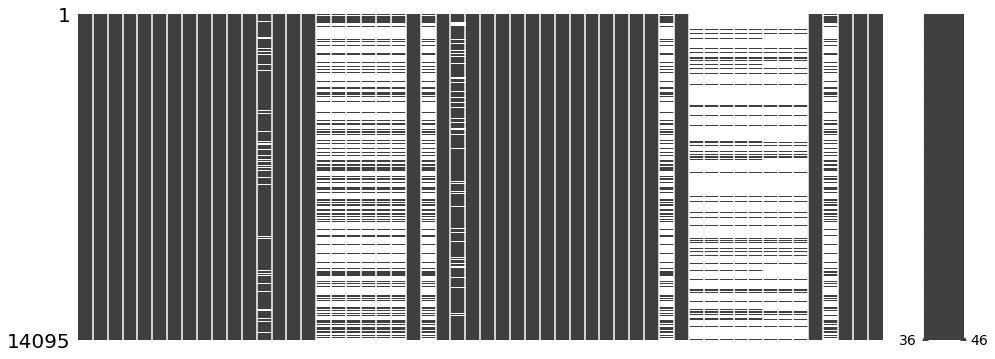

In [190]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [191]:
# 데이터를 콤포넌트별로 쪼개기

In [192]:
train["COMPONENT_ARBITRARY"].value_counts().index

Index(['COMPONENT3', 'COMPONENT1', 'COMPONENT2', 'COMPONENT4'], dtype='object')

In [193]:
train[train["COMPONENT_ARBITRARY"] == "COMPONENT3"]

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
5,TRAIN_00005,COMPONENT3,2061,2008,4,550,0,3,8,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,69.7,1015,0
6,TRAIN_00006,COMPONENT3,1416,2015,7,616,0,0,21,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,148.5,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,TRAIN_14082,COMPONENT3,3060,2010,2,200,0,2,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,140.0,35,1
14086,TRAIN_14086,COMPONENT3,1637,2008,16,487,0,11,99,2,...,NaN,NaN,NaN,NaN,NaN,0,NaN,152.6,21,1
14088,TRAIN_14088,COMPONENT3,1311,2010,6,511,0,0,20,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,128.9,20,0
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0


In [194]:
train_c1 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT1"]
train_c2 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT2"]
train_c3 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT3"]
train_c4 = train[train["COMPONENT_ARBITRARY"] == "COMPONENT4"]

In [195]:
train_list = [train_c1, train_c2, train_c3, train_c4]

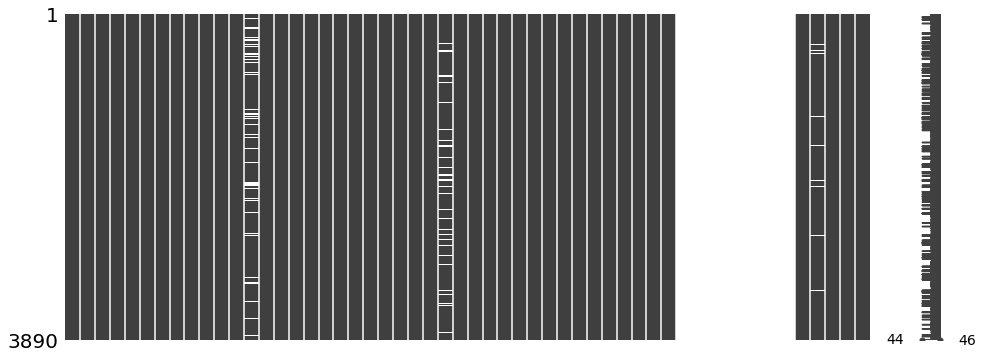

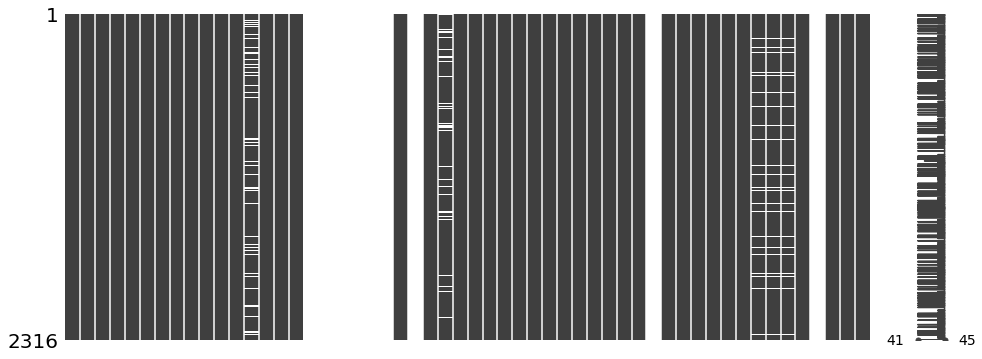

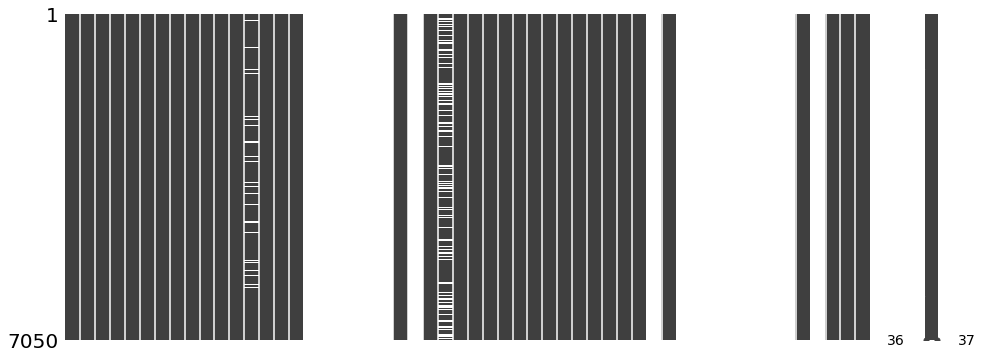

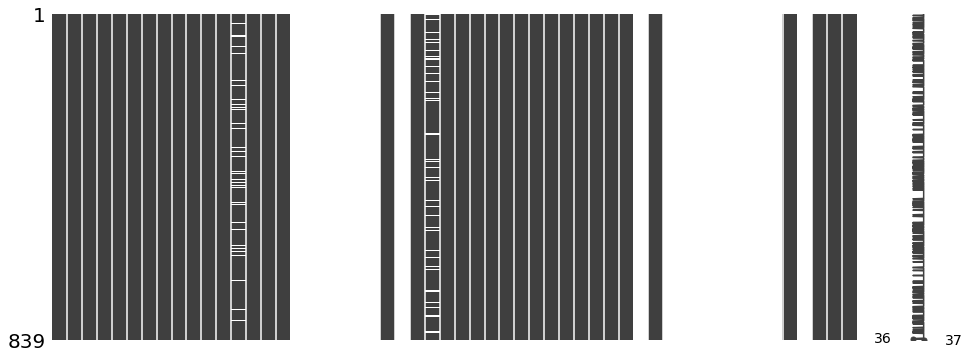

In [196]:
import missingno as msno
for i in train_list:
    msno.matrix(i, figsize=(16,6))

In [197]:
for i in train_list:
    for col in i.columns.tolist():
        if i[col].isna().any():
            try:
                최빈값 = i[col].mode().values[0]
                print(최빈값)
                i[col].fillna(최빈값, inplace=True)
            except:
                i[col].fillna(i.groupby(["YEAR"])[col].transform("median"),inplace=True)
        else:
            pass
    print("부분 작업 완료")

0.0
2.0
13.3
부분 작업 완료
0.0
0.0
14.0
300.0
6789.0
부분 작업 완료
0.0
0.0
부분 작업 완료
0.0
2.0
부분 작업 완료


(3890, 54)
--------------------------------------------------
(2316, 54)
--------------------------------------------------
(7050, 54)
--------------------------------------------------
(839, 54)
--------------------------------------------------


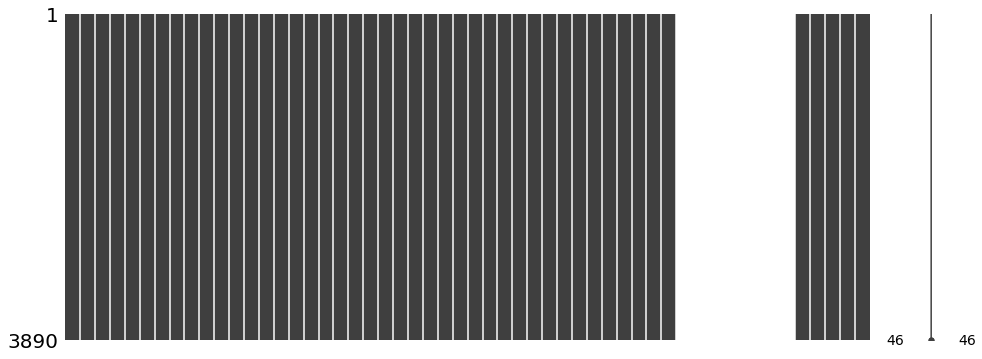

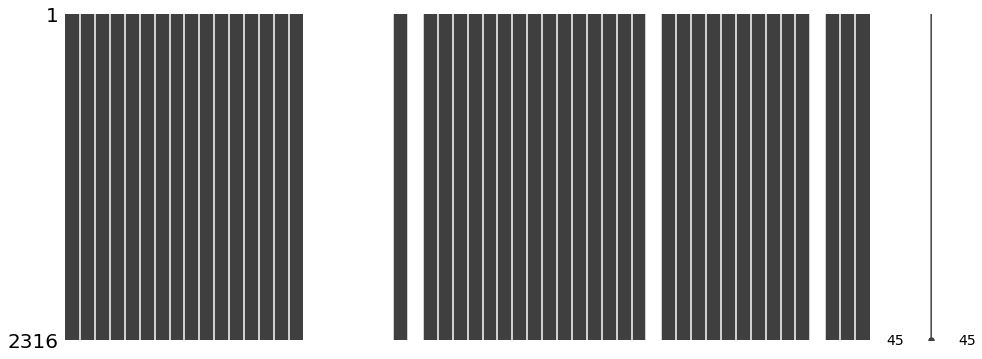

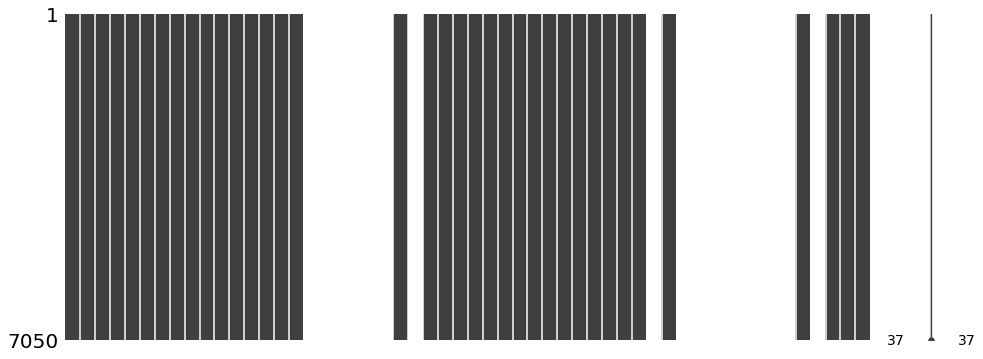

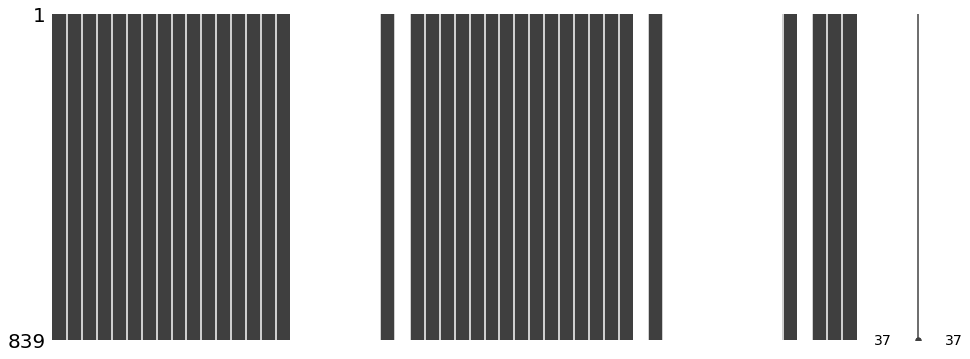

In [198]:
for i in train_list:
    print(i.shape)
    msno.matrix(i, figsize=(16,6))
    print("-"*50)

In [199]:
for i in train_list:
    null_cols = []
    for col in i.columns.tolist():
        if i[col].isna().any():
            null_cols.append(col)
        else:
            pass
    print(len(null_cols))
    print(f"{null_cols}")
    i.drop(columns = null_cols, axis = 1, inplace = True)
    

8
['U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4']
9
['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'V100']
17
['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']
17
['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


(3890, 46)
(2316, 45)
(7050, 37)
(839, 37)


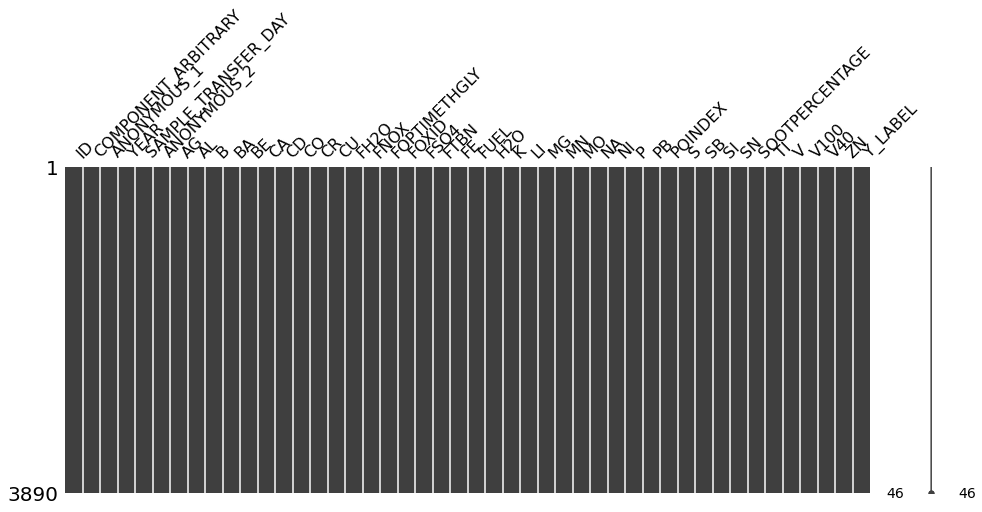

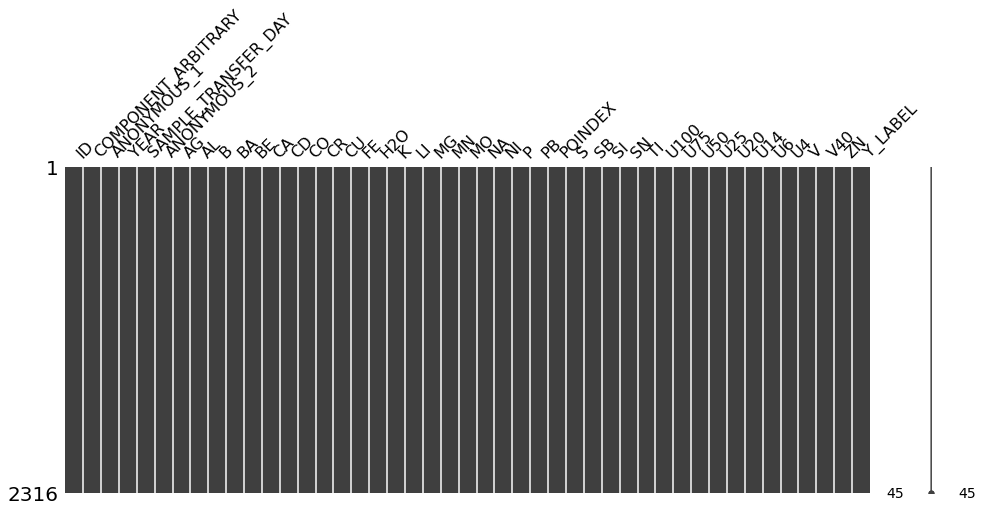

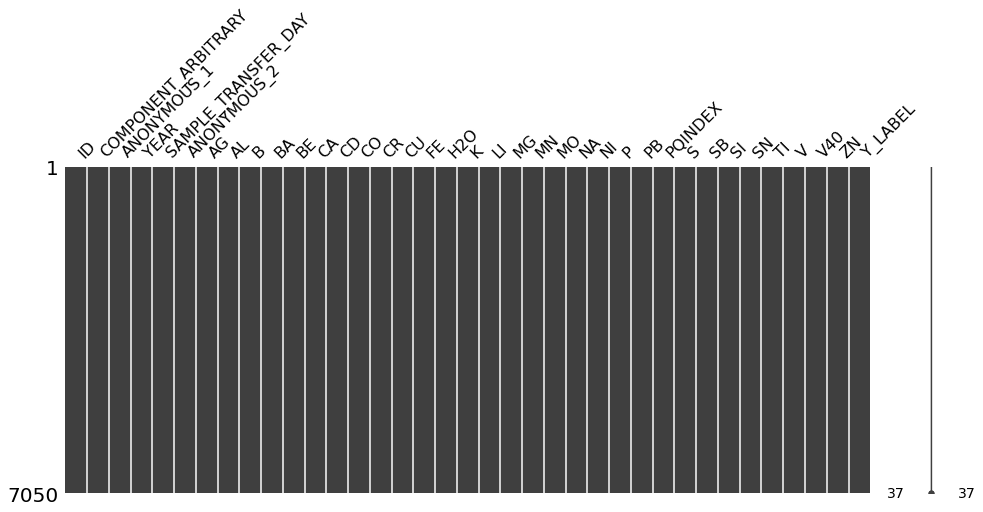

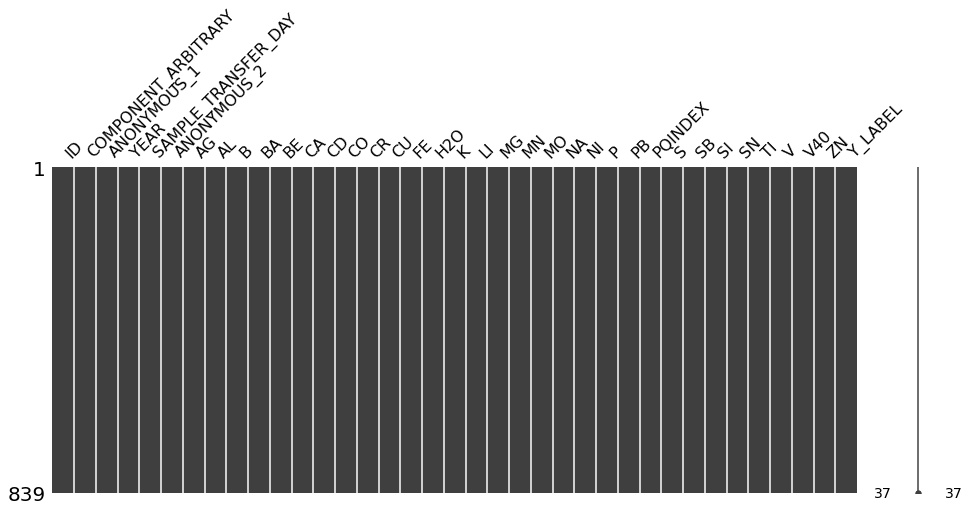

In [200]:
for i in train_list:
    print(i.shape)
    msno.matrix(i, figsize=(16,6))

In [201]:
# test.head(15)

In [202]:
test["order"] = [i for i in range(test.shape[0])]

In [203]:
test_c1 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT1"]
test_c2 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT2"]
test_c3 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT3"]
test_c4 = test[test["COMPONENT_ARBITRARY"] == "COMPONENT4"]
test_list = [test_c1, test_c2, test_c3, test_c4]

In [204]:
test_c1.head(2)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,order
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091,0
11,TEST_0011,COMPONENT1,2033,2016,200,0,0,2,4,27,0.0,0,174,0,15,0,0,127.1,1188,11


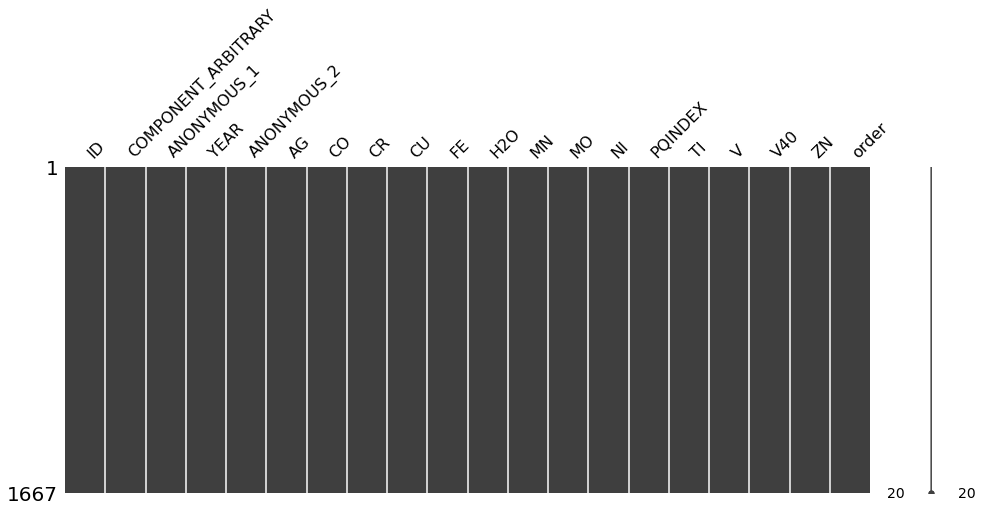

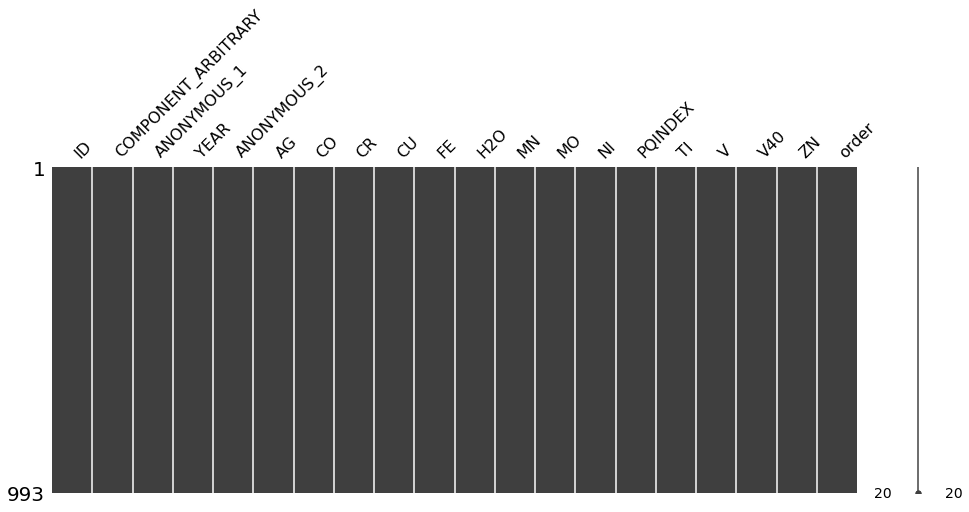

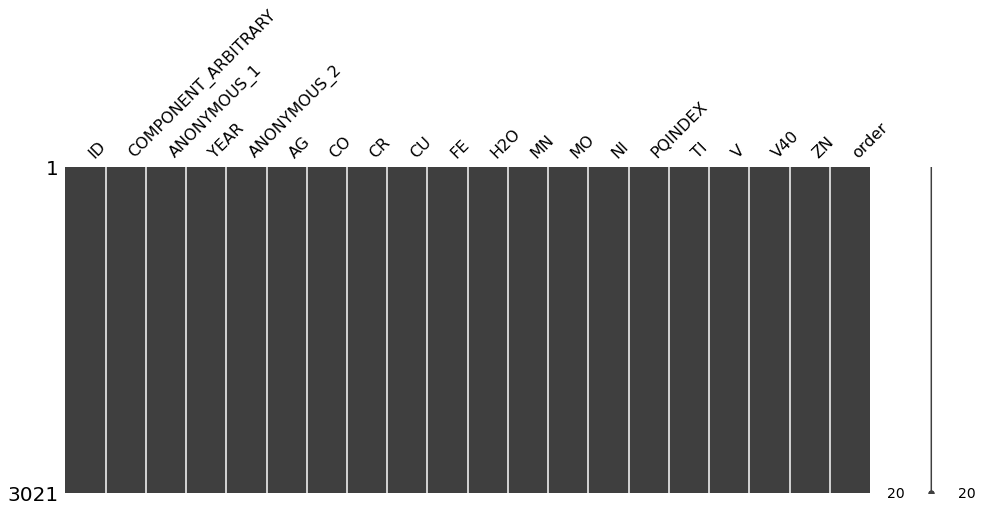

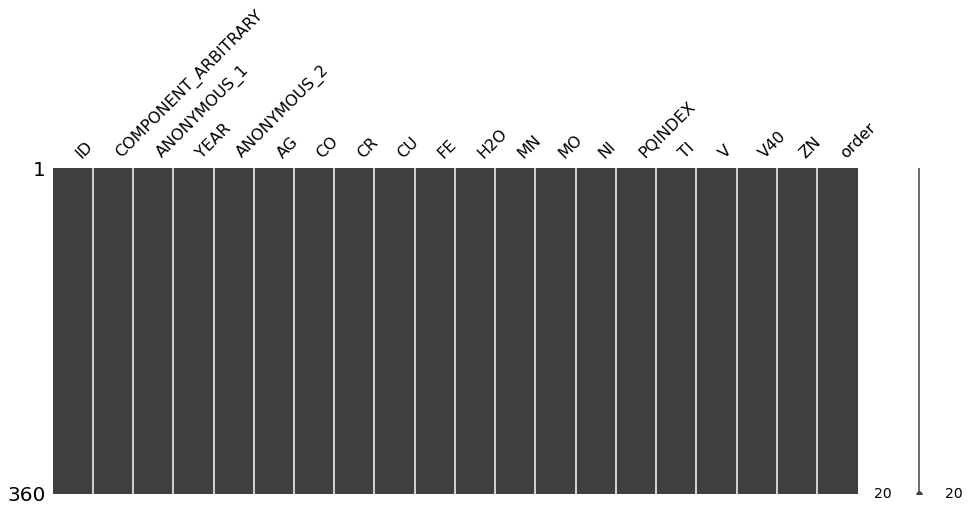

In [205]:
for i in test_list:
    msno.matrix(i, figsize=(16,6))

In [206]:
# y1 = [2007, 2008, 2009, 2010]
# y2 = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# def year_grouping(year):
#     if year in y1:
#         return "y1"
#     elif year in y2:
#         return "y2"

In [207]:
# for i in train_list:
    
#     i["YEAR"] = i["YEAR"].apply(year_grouping)
#     i["YEAR"].value_counts()

In [208]:
# for k in test_list:

#     k["YEAR"] = k["YEAR"].apply(year_grouping)
#     k["YEAR"].value_counts()

In [209]:
# s1 = [100000]
# s2 = [200000]

# def sample_day_grouping(day):
#     if day in s1:
#         return "s1"
#     elif day in s2:
#         return "s2"
#     else:
#         return "s3" 


In [210]:

# for i in train_list:
    
#     i["SAMPLE_TRANSFER_DAY"] = i["SAMPLE_TRANSFER_DAY"].apply(sample_day_grouping)
#     i["SAMPLE_TRANSFER_DAY"].value_counts()

## (3) Scaling

In [211]:
train_c1.describe()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,SB,SI,SN,SOOTPERCENTAGE,TI,V,V100,V40,ZN,Y_LABEL
count,3890.000000,3890.000000,3890.000000,3890.00000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,...,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000
mean,3046.162468,2013.729563,7.731620,392.90617,0.025193,10.285861,62.665553,0.643445,0.012596,1397.478406,...,0.386375,9.761183,2.056812,0.609254,0.055013,0.024422,13.564442,102.678103,1161.010283,0.080206
std,2979.489071,3.929682,12.318999,624.59827,0.170859,62.124561,98.994245,2.161781,0.252721,1497.840723,...,0.888525,15.240872,3.494714,0.652382,0.564718,0.157670,1.052036,13.029131,177.401876,0.271646
min,1000.000000,2007.000000,0.000000,200.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.200000,22.800000,37.000000,0.000000
25%,1647.250000,2011.000000,3.000000,200.00000,0.000000,1.000000,3.000000,0.000000,0.000000,46.000000,...,0.000000,5.000000,0.000000,0.200000,0.000000,0.000000,13.000000,94.000000,1048.000000,0.000000
50%,2225.500000,2014.000000,5.000000,200.00000,0.000000,2.000000,11.000000,0.000000,0.000000,211.000000,...,0.000000,8.000000,1.000000,0.400000,0.000000,0.000000,13.500000,100.700000,1150.000000,0.000000
75%,3724.750000,2017.000000,8.000000,391.00000,0.000000,4.000000,107.000000,0.000000,0.000000,3002.000000,...,0.000000,11.000000,2.000000,0.800000,0.000000,0.000000,14.200000,111.800000,1283.000000,0.000000
max,71569.000000,2022.000000,368.000000,9650.00000,2.000000,1515.000000,548.000000,58.000000,9.000000,5012.000000,...,10.000000,420.000000,28.000000,6.500000,27.000000,2.000000,29.900000,202.600000,2132.000000,1.000000


In [212]:
categorical_features = ['ID','COMPONENT_ARBITRARY','SAMPLE_TRANSFER_DAY', 'YEAR', "Y_LABEL", "order"]

In [213]:
def get_values(value):
    return value.values.reshape(-1, 1)

for a, b in zip(train_list, test_list):

    for col in a.columns:
        
        if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화

            scaler = scaler
            a[col] = scaler.fit_transform(get_values(a[col]))
            
            if col in b.columns:
                b[col] = scaler.transform(get_values(b[col]))

In [214]:
train_c1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3890 entries, 9 to 14091
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   3890 non-null   object 
 1   COMPONENT_ARBITRARY  3890 non-null   object 
 2   ANONYMOUS_1          3890 non-null   float64
 3   YEAR                 3890 non-null   int64  
 4   SAMPLE_TRANSFER_DAY  3890 non-null   int64  
 5   ANONYMOUS_2          3890 non-null   float64
 6   AG                   3890 non-null   float64
 7   AL                   3890 non-null   float64
 8   B                    3890 non-null   float64
 9   BA                   3890 non-null   float64
 10  BE                   3890 non-null   float64
 11  CA                   3890 non-null   float64
 12  CD                   3890 non-null   float64
 13  CO                   3890 non-null   float64
 14  CR                   3890 non-null   float64
 15  CU                   3890 non-null   

In [215]:
test_c1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1667 entries, 0 to 6040
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1667 non-null   object 
 1   COMPONENT_ARBITRARY  1667 non-null   object 
 2   ANONYMOUS_1          1667 non-null   float64
 3   YEAR                 1667 non-null   int64  
 4   ANONYMOUS_2          1667 non-null   float64
 5   AG                   1667 non-null   float64
 6   CO                   1667 non-null   float64
 7   CR                   1667 non-null   float64
 8   CU                   1667 non-null   float64
 9   FE                   1667 non-null   float64
 10  H2O                  1667 non-null   float64
 11  MN                   1667 non-null   float64
 12  MO                   1667 non-null   float64
 13  NI                   1667 non-null   float64
 14  PQINDEX              1667 non-null   float64
 15  TI                   1667 non-null   f

## (2) 왜도 검토 - `Log Transform`

In [216]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL", "order"]
for i in train_list:
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    print(len(numerical_cols))
    skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    print(skewness)
    print("="*50)


41
PQINDEX           47.149105
H2O               46.540531
K                 46.020011
TI                31.502972
NA                29.003241
BE                27.982542
NI                23.162126
CO                21.039555
LI                20.121551
CR                16.407399
AL                15.912250
SI                14.943964
CD                14.395496
FE                13.625990
BA                13.249430
CU                12.716306
FH2O              12.364062
ANONYMOUS_1       11.693952
ANONYMOUS_2        8.703758
PB                 8.600347
FUEL               7.702714
AG                 7.394177
V                  6.554351
MN                 4.914686
FOPTIMETHGLY       3.680244
SB                 3.525168
MG                 3.438126
SOOTPERCENTAGE     3.124869
SN                 2.978914
FSO4               2.801530
FNOX               2.789648
FOXID              2.615895
B                  2.253489
S                  1.103691
MO                 1.079082
V100             

In [217]:
# #박스 플롯
def box_plot(df):
    세로열 = 3
    가로열 = int(len(numerical_cols)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
    a = 0
    for i, col in enumerate(numerical_cols):
            b=i%3
            sns.boxplot(ax=axes[a, b], data=df, x='Y_LABEL', y=col)
            if b == 2:
                a += 1

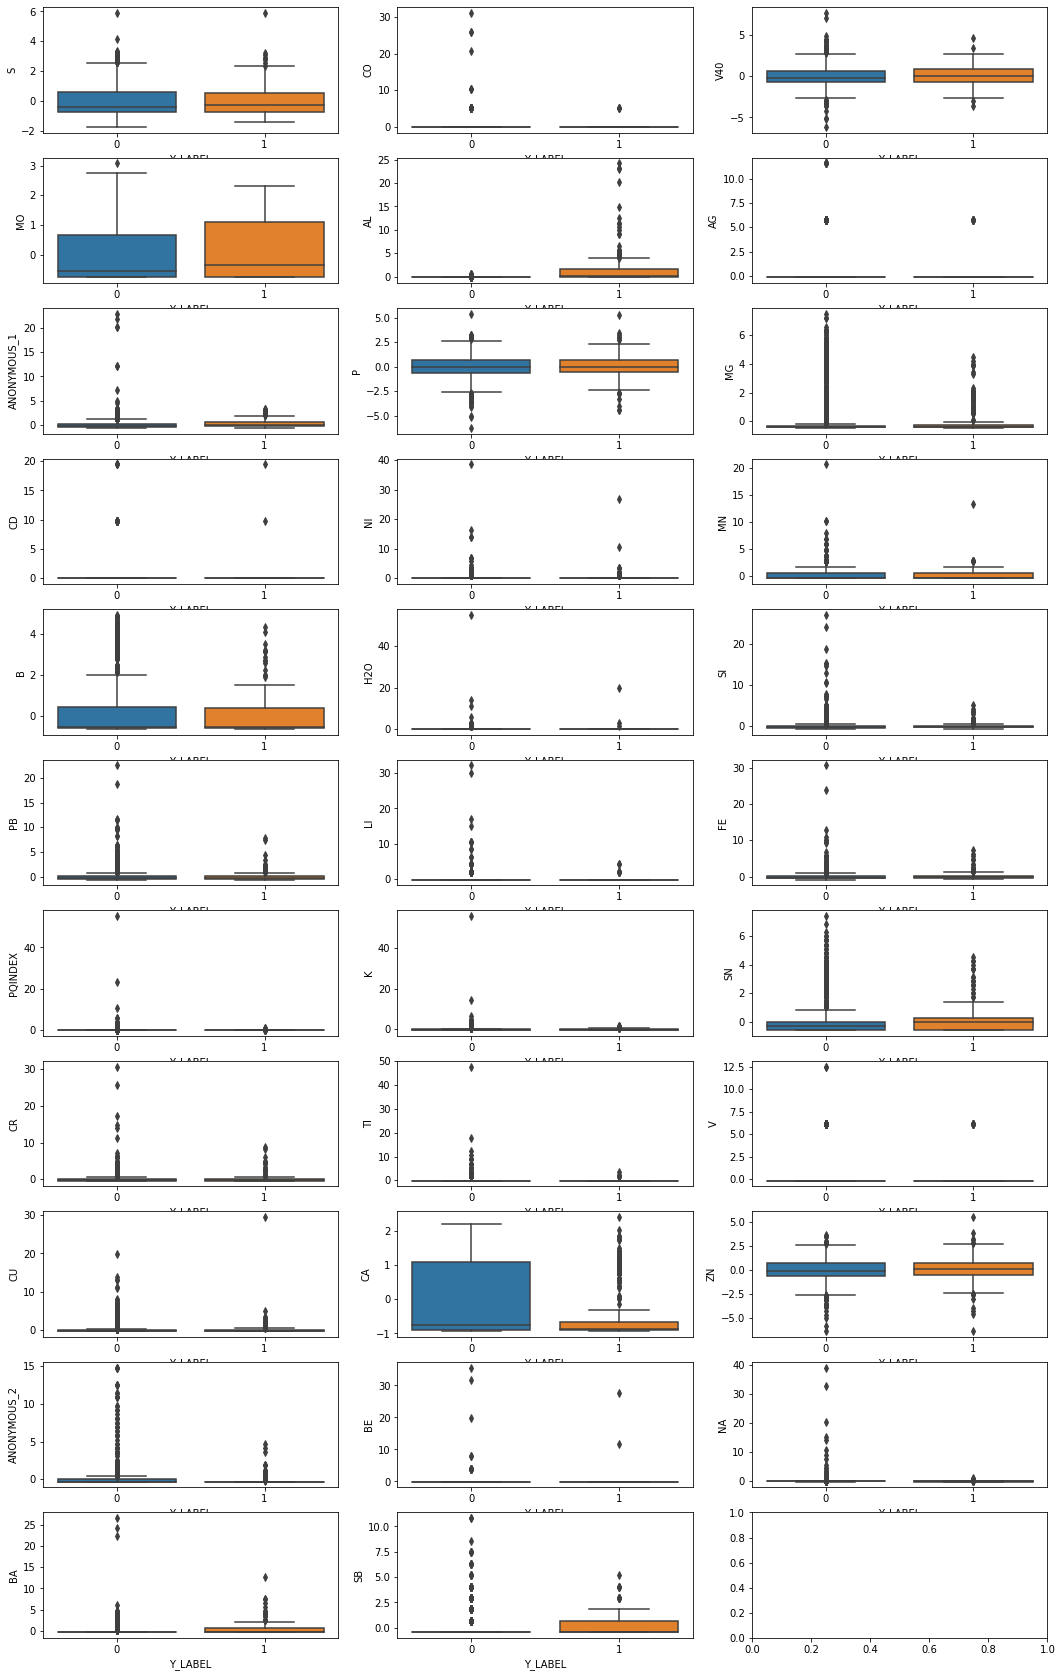

In [218]:
box_plot(train_c1)

In [219]:
def skew_chart(df):
    세로열 = 3
    가로열 = int(len(df.columns)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
    a = 0
    for i, col in enumerate(skew_feats):
        b=i%3
        sns.distplot(df[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

In [220]:
# skew_chart(train_c1)

In [221]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL", "order"]

for i in tqdm(train_list):
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    
    
    num = 1
    for turn in range(CFG["log_transform_turn"]):
        print(f"{num}번째 스큐 피팅 +++++++++++++++++++++++++++++++")
        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
#         print("로그변환 전 왜도값")
#         print(skewness)
        
        skew_feats = skewness[skewness > CFG["skew_cut"]].index
        print(f"skew_cut값 초과 칼럼 개수: {len(skew_feats)}")
        
        
        log_train = i[skew_feats].copy()
        log_train[skew_feats] = np.log1p(log_train[skew_feats])


        for col in skew_feats:
            i[col] = log_train[col]
        

        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
#         print("로그변환 후 왜도값")
#         print(skewness)
        print("-"*50)
    
        num += 1
        
    print("="*50)



  0%|          | 0/4 [00:00<?, ?it/s]

1번째 스큐 피팅 +++++++++++++++++++++++++++++++
skew_cut값 초과 칼럼 개수: 39
--------------------------------------------------
1번째 스큐 피팅 +++++++++++++++++++++++++++++++
skew_cut값 초과 칼럼 개수: 39
--------------------------------------------------
1번째 스큐 피팅 +++++++++++++++++++++++++++++++
skew_cut값 초과 칼럼 개수: 31
--------------------------------------------------
1번째 스큐 피팅 +++++++++++++++++++++++++++++++
skew_cut값 초과 칼럼 개수: 28
--------------------------------------------------


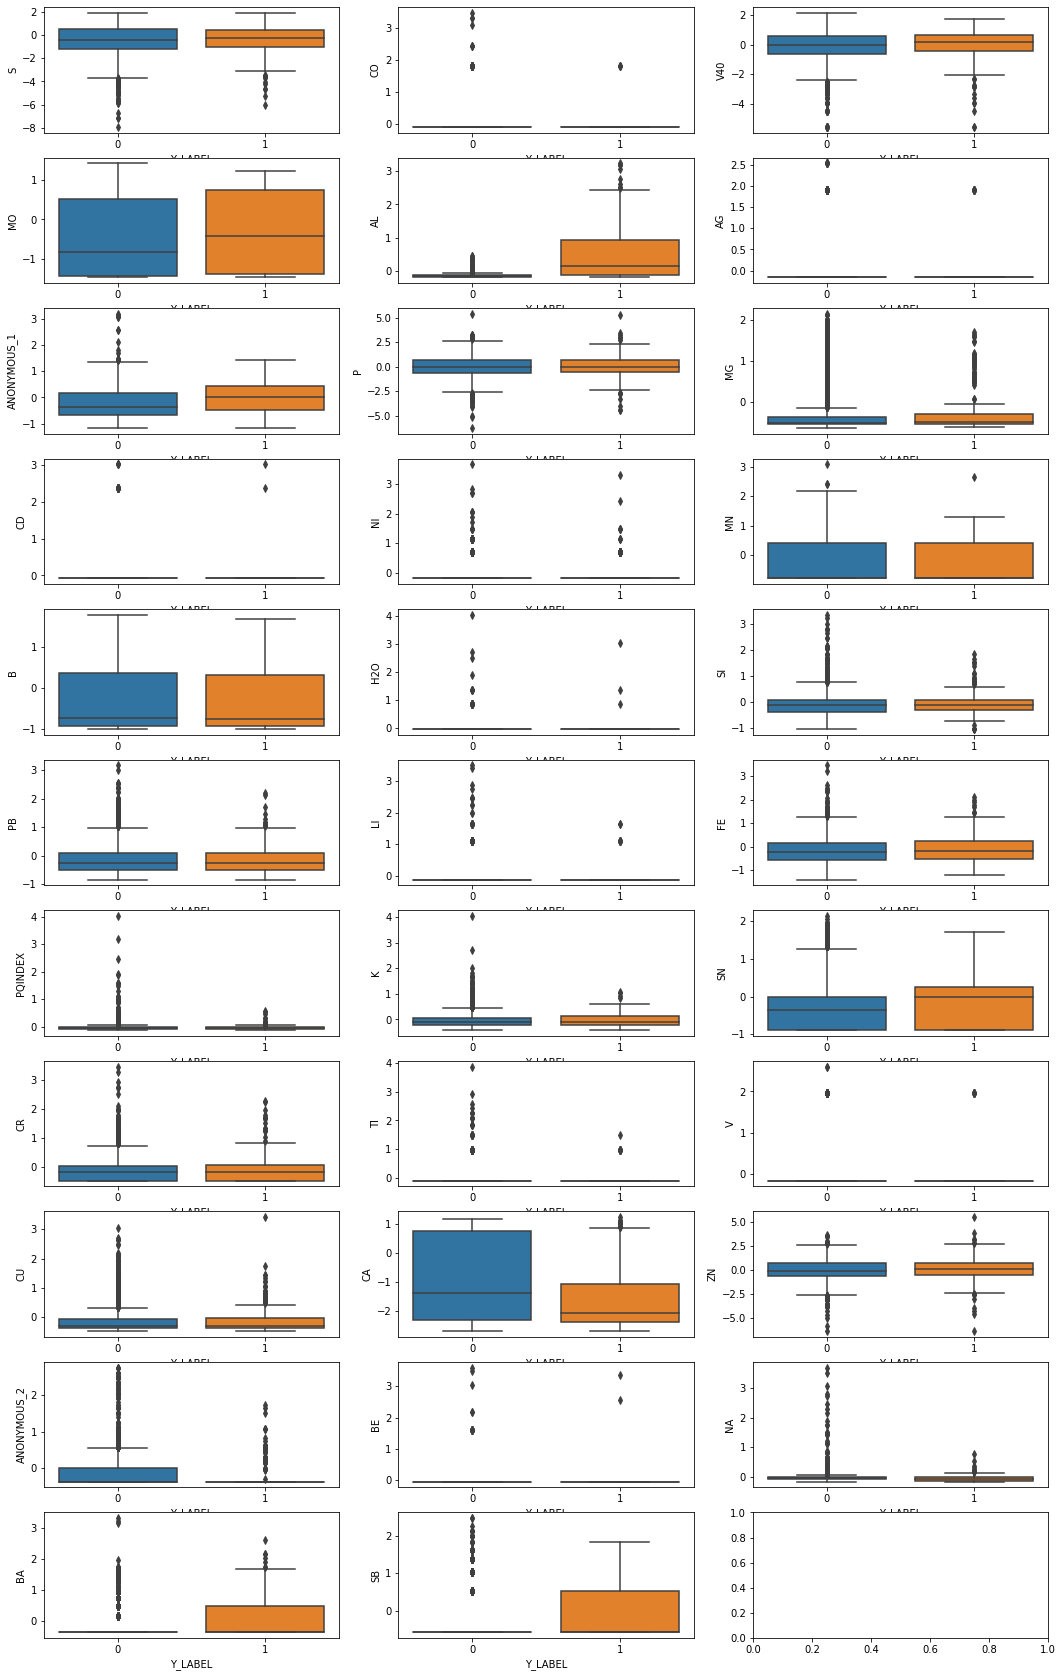

In [222]:
box_plot(train_c1)

In [223]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL", "order"]

for i in tqdm(test_list):
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    
    for turn in range(CFG["log_transform_turn"]):
        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
        
        
        skew_feats = skewness[skewness > CFG["skew_cut"]].index
        log_train = i[skew_feats].copy()
        log_train[skew_feats] = np.log1p(log_train[skew_feats])

        for col in skew_feats:
            i[col] = log_train[col]

        skewness = i[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
#         print(skewness)
#         print("="*50)


  0%|          | 0/4 [00:00<?, ?it/s]

In [224]:
# train_c1.info()

<AxesSubplot:>

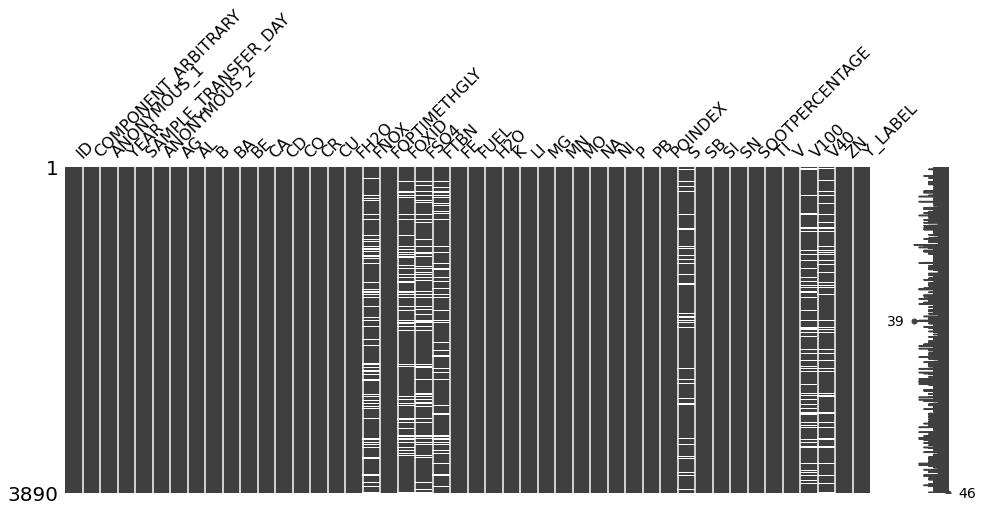

In [225]:
msno.matrix(train_c1, figsize=(16,6))

In [226]:
train_c1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3890 entries, 9 to 14091
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   3890 non-null   object 
 1   COMPONENT_ARBITRARY  3890 non-null   object 
 2   ANONYMOUS_1          3890 non-null   float64
 3   YEAR                 3890 non-null   int64  
 4   SAMPLE_TRANSFER_DAY  3890 non-null   int64  
 5   ANONYMOUS_2          3890 non-null   float64
 6   AG                   3890 non-null   float64
 7   AL                   3890 non-null   float64
 8   B                    3890 non-null   float64
 9   BA                   3890 non-null   float64
 10  BE                   3890 non-null   float64
 11  CA                   3890 non-null   float64
 12  CD                   3890 non-null   float64
 13  CO                   3890 non-null   float64
 14  CR                   3890 non-null   float64
 15  CU                   3890 non-null   

In [227]:
train_c1.FNOX.value_counts()

-0.946273    969
-0.077243    956
 0.380588    687
 0.693459    372
 0.931417    167
 1.123495     76
 1.284556     27
 1.423239     16
 1.545011      8
 1.653551      7
 1.751455      3
 1.840623      3
 2.134211      2
 2.308847      1
 2.867190      1
 1.998153      1
 2.195875      1
 2.360882      1
Name: FNOX, dtype: int64

## (4) 다중공선성 검토

In [228]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [229]:
for i in train_list:
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    a = i.copy()
    a = a[numerical_cols].astype(float)
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(a.values, k) for k in range(a.shape[1])]
    vif["features"] = a.columns 
    vif.sort_values(by='VIF_Factor', ascending=False)
    print(vif)
    vif_cut = vif[vif["VIF_Factor"]> CFG["vif_cut"]]
    vif_drop = vif_cut["features"].tolist()
    print(vif_drop)
    vif_drop
    i = i.drop(vif_drop,axis=1)
    print(len(i.columns))


MissingDataError: exog contains inf or nans

In [ ]:
for i in test_list:
    print(len(i.columns))
    numerical_cols = list(set(i.columns.tolist())-set(not_number_features))
    a = i.copy()
    a = a[numerical_cols].astype(float)
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(a.values, k) for k in range(a.shape[1])]
    vif["features"] = a.columns 
    print(vif)
    vif_cut = vif[vif["VIF Factor"]> CFG["vif_cut"]]
    vif_drop = vif_cut["features"].tolist()
    print(vif_drop)
    vif_drop
    i = i.drop(vif_drop,axis=1)
    print(len(i.columns))
    print("="*50)


In [ ]:
test_c1.head(2)

## (5) 상관관계 검토

In [ ]:
# train.columns

In [ ]:
for i in train_list:
    fig = plt.figure(figsize=(30, 5))
    sns.heatmap(i.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [ ]:
for i in train_list:
    df_corr = pd.DataFrame(i.corr()["Y_LABEL"].sort_values(ascending=False))
    print(df_corr)
    print("="*50)

In [ ]:
# 상관관계가 낮아서 제낄 칼럼 확인
num = 0
for i, k in zip(train_list, test_list):
    cutline = CFG["corr_cut"]
    df_corr = pd.DataFrame(i.corr()["Y_LABEL"].sort_values(ascending=False))
    df_corr1 = df_corr[(df_corr["Y_LABEL"] < cutline[num]) & (df_corr["Y_LABEL"] > (cutline[num]*-1))]
    print(f"상관계수 커트라인 : {cutline[num]}, 드랍 칼럼 개수 : {len(df_corr1.index)}")
#     df_corr1.sort_values
    drop_columns = df_corr1.index.tolist()
    print(drop_columns)
    print(f"train 드랍하기 전 칼럼 갯수 : {len(i.columns)}")
    for col in drop_columns:
        if col in i.columns:
            i.drop(columns = col, axis = 1, inplace = True)
        else:
            pass
    print(f"train 드랍후 칼럼 갯수 : {len(i.columns)}")
    
    print(f"test 드랍하기 전 칼럼 갯수 : {len(k.columns)}")
    for col in drop_columns:
        if col in k.columns:
            k.drop(columns = col, axis = 1, inplace = True)
        else:
            pass
    print(f"test 드랍후 칼럼 갯수 : {len(k.columns)}")
    
    num += 1
    
    print("="* 50)
    

In [ ]:
train_c1.head(2)

In [ ]:
test_c1.head(2)

In [ ]:
train_c1.shape, train_c2.shape, train_c3.shape, train_c4.shape

In [ ]:
test_c1.shape, test_c2.shape, test_c3.shape, test_c4.shape

## (7) 인코딩

In [ ]:
def onehot_encode(df, target_cols):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False),target_cols)], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [ ]:
import pickle
import plotly.express as px
from sklearn.decomposition import PCA


In [ ]:
num = 1
for i, k in zip(train_list, test_list):
    i.drop(columns = "ID", axis = 1, inplace = True)
    k.drop(columns = "ID", axis = 1, inplace = True)
    i = onehot_encode(i, [0, 2])
    k = onehot_encode(k, [0, 2])


    for a in range(0, len(i.columns)):
        i.iloc[:,a] = pd.to_numeric(i.iloc[:,a], errors='ignore')
    
    for b in range(0, len(k.columns)):
        k.iloc[:,b] = pd.to_numeric(k.iloc[:,b], errors='ignore')
    
    all_X = i.drop(['Y_LABEL'], axis = 1)
    all_y = i['Y_LABEL']
      
    
    train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

    pca = PCA(n_components=3)

    components = pca.fit_transform(train_X)

    total_var = pca.explained_variance_ratio_.sum() * 100

    fig = px.scatter_3d(
        components, x=0, y=1, z=2, color=train_y,
        title=f'Total Explained Variance: {total_var:.2f}%',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
    )
    fig.show()
    
  
    
    #저장하기
    with open(f"./data/{file_version}_{num}_train_X", 'wb') as pickle_filename:
        pickle.dump(train_X, pickle_filename)

    with open(f"./data/{file_version}_{num}_train_y", 'wb') as pickle_filename:
        pickle.dump(train_y, pickle_filename)

    with open(f"./data/{file_version}_{num}_val_X", 'wb') as pickle_filename:
        pickle.dump(val_X, pickle_filename)

    with open(f"./data/{file_version}_{num}_val_y", 'wb') as pickle_filename:
        pickle.dump(val_y, pickle_filename)

    with open(f"./data/{file_version}_{num}_test", 'wb') as pickle_filename:
        pickle.dump(k, pickle_filename)
    
    num += 1

print("작업 완료")

In [ ]:
train_X.columns